# Raw Risk Premias

This notebook will look at the raw risk premia returns that are generated by being long Fallen Angels and short some other bond ETF. The overall goal of this is to set a benchmark for the risk premia compensation. 

## Packages

In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from RiskPremia import RiskPremia

In [3]:
def get_data() -> pd.DataFrame: 
    
    df_equal = (RiskPremia().calculate_equal_spread().assign(
        rtn = "equal").
        drop(columns = ["bnd_rtn", "angl_rtn"]))

    df_dur = (RiskPremia().calculate_duration_neutral_spread().assign(
        angl_rtn = lambda x: x.angl_rtn * x.angl_weight,
        bnd_rtn  = lambda x: x.bnd_rtn * x.bnd_weight,
        spread   = lambda x: x.angl_rtn - x.bnd_rtn,
        rtn      = "dur_neutral")
        [["date", "spread", "angl_sec", "bnd_sec", "rtn"]])

    df = (pd.concat([
        df_equal, df_dur]))
    
    return df

df         = get_data()
ig_tickers = ["AGG", "LQD"]

## Examine Returns

In [4]:
def plot_rtn_spread(df: pd.DataFrame, suptitle: str) -> plt.Figure:
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20,10))

    angl_secs = df.angl_sec.drop_duplicates().sort_values().to_list()
    for i, angl_sec in enumerate(angl_secs):

        df_tmp = (df.query(
            "angl_sec == @angl_sec"))

        (df_tmp.query(
            "bnd_sec == @ig_tickers").
            rename(columns = {"bnd_sec": ""}).
            pivot(index = "date", columns = "", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax    = axes[0,i],
                title = "Long: " + angl_sec + " Short: Investment Grade"))

        (df_tmp.query(
            "bnd_sec != @ig_tickers").
            rename(columns = {"bnd_sec": ""}).
            pivot(index = "date", columns = "", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax = axes[1,i],
                title = "Long: " + angl_sec + " Short: Investment Grade"))

    for ax in axes.flatten():

        ax.set_ylabel("Cumuative Return (%)")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle(suptitle)
    plt.tight_layout()

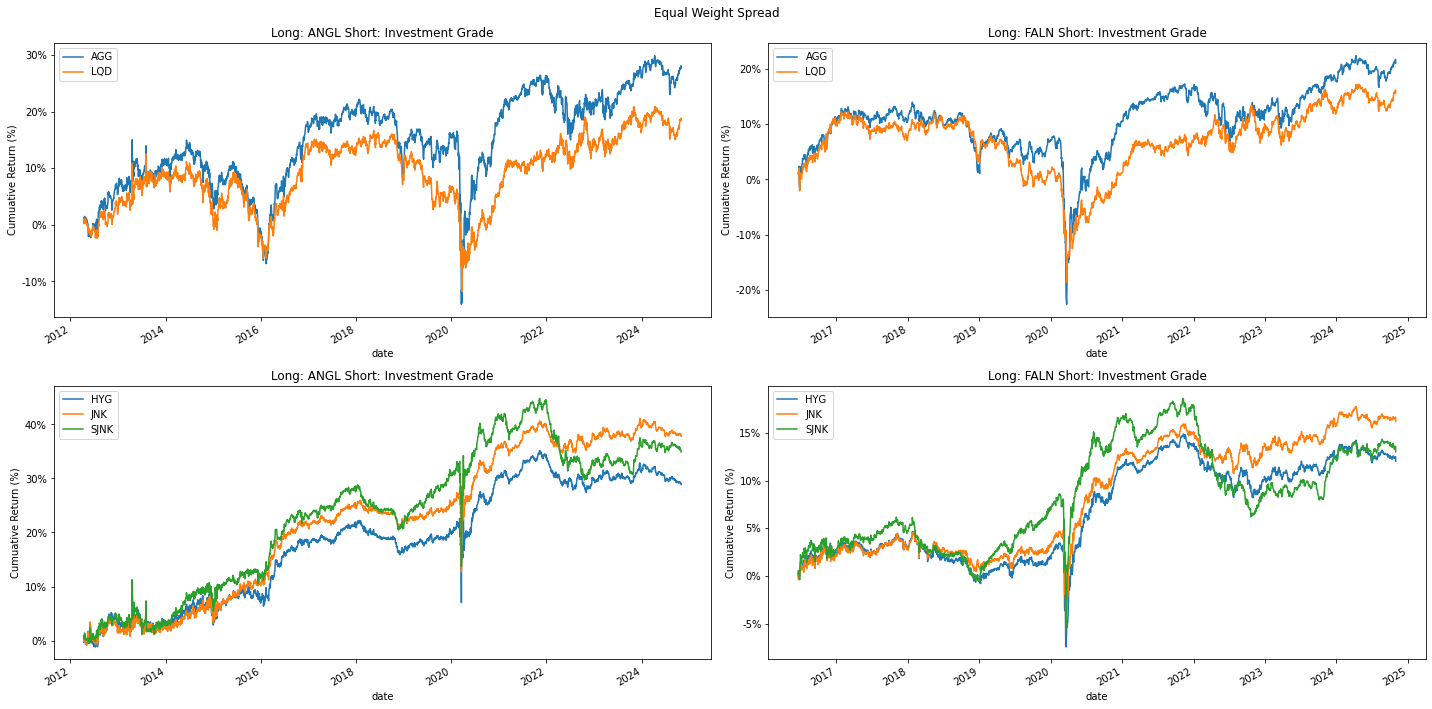

In [5]:
plot_rtn_spread(df.query("rtn == 'equal'"), suptitle = "Equal Weight Spread")

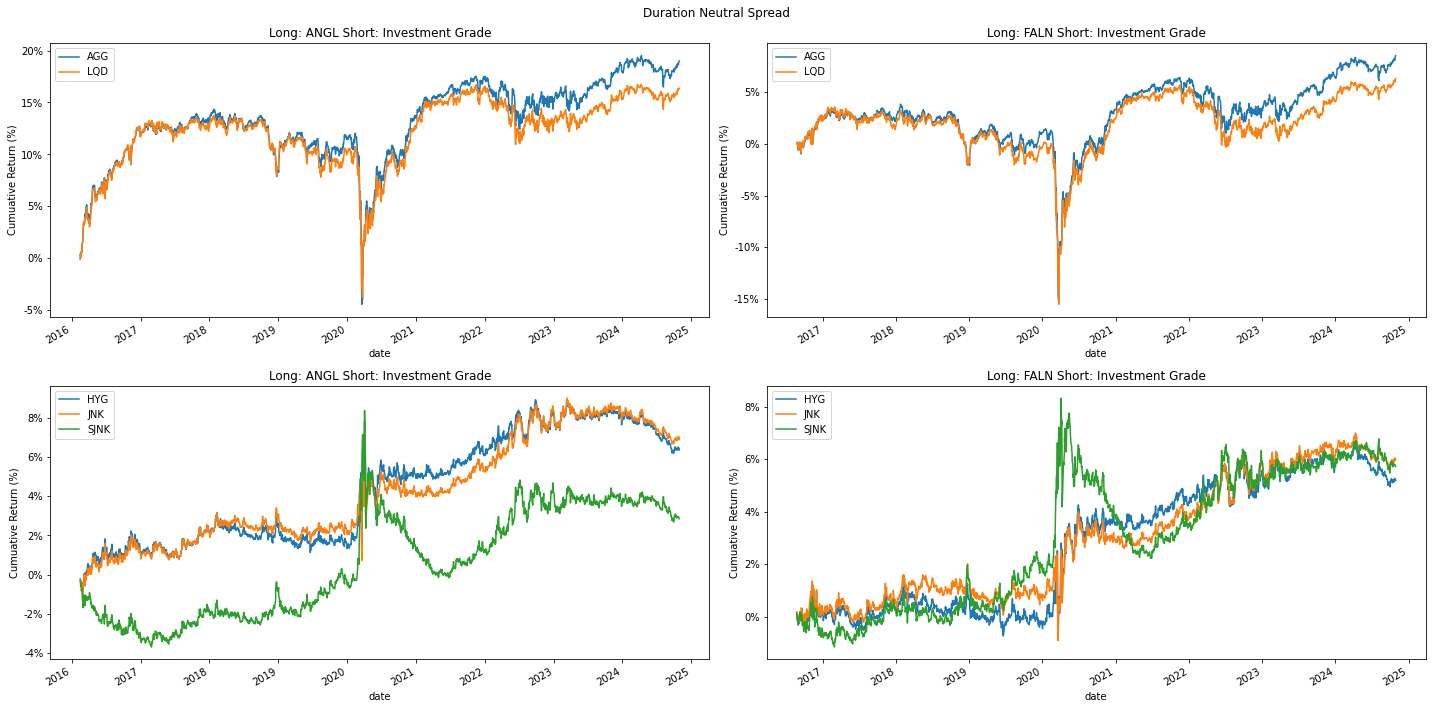

In [6]:
plot_rtn_spread(df.query("rtn == 'dur_neutral'"), suptitle = "Duration Neutral Spread")

In [7]:
def calculate_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.drop(
        columns = ["date"]).
        groupby(["bnd_sec", "angl_sec", "rtn"]).
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = calculate_sharpe(df)

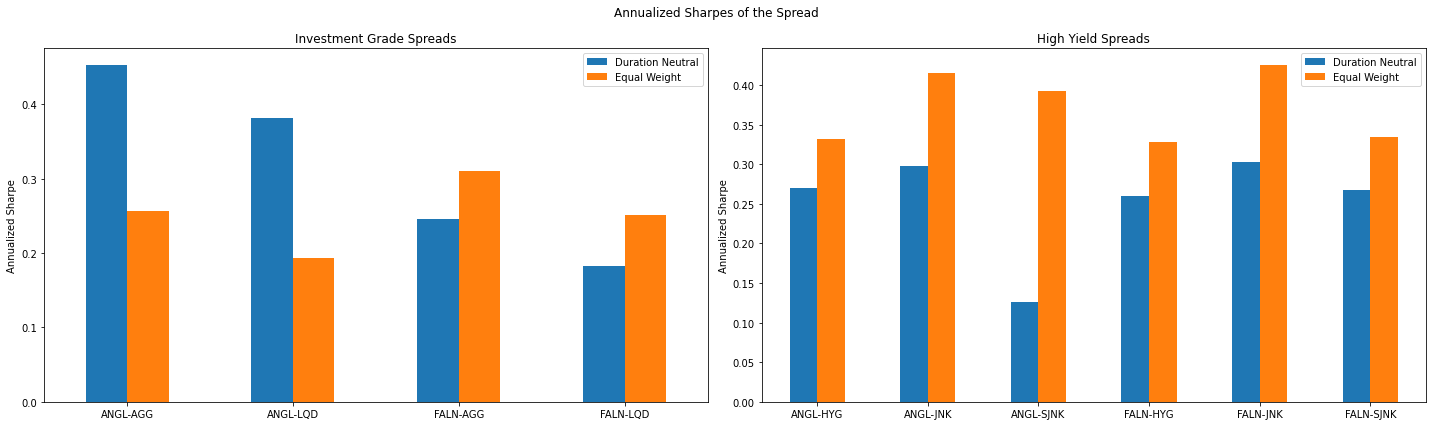

In [8]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_sharpe.assign(
        spread_name = lambda x: x.angl_sec + "-" + x.bnd_sec).
        query("bnd_sec == @ig_tickers").
        rename(columns = {"rtn": ""}).
        pivot(index = "spread_name", columns = "", values = "sharpe").
        rename(columns = {
            "dur_neutral": "Duration Neutral",
            "equal"      : "Equal Weight"}).
        plot(
            kind   = "bar",
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe",
            ax     = axes[0],
            title  = "Investment Grade Spreads"))

    (df_sharpe.assign(
        spread_name = lambda x: x.angl_sec + "-" + x.bnd_sec).
        query("bnd_sec != @ig_tickers").
        rename(columns = {"rtn": ""}).
        pivot(index = "spread_name", columns = "", values = "sharpe").
        rename(columns = {
            "dur_neutral": "Duration Neutral",
            "equal"      : "Equal Weight"}).
        plot(
            kind   = "bar",
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe",
            ax     = axes[1],
            title  = "High Yield Spreads"))
    
    fig.suptitle("Annualized Sharpes of the Spread")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)